# Can We Finally Crack the Code? Is there any way to accurately predict the success of an NFL prospect?

## The NFL Draft

The NFL Draft is a holiday for us football fans! It's a time to gather with our friends, family, and fellow fans to watch as our favorite teams make critical decisions that will shape the future of their franchise. With the anticipation of the first pick, we hold our breath and wait for the announcement, wondering who will be the next superstar to grace our team's roster. It's a time of hope, excitement, and endless possibilities as we watch talented young athletes achieve their dreams and make their way to the big leagues. And with each pick, we cheer, we debate, we celebrate, and we commiserate, as we share in the ups and downs of the draft together. 

### HOWEVER

How many players really live up to the hype? How many are doomed to be "busts"? And why does it seem like there is always a diamond in the rough that ends up being a Hall of Famer despite being picked 199th overall (TB <3)?  With all the advancements in scouting, analytics, and technology, why can't we seem to get this right? 

### Let's throw our hats in the ring and give it a go!

Let's see if we could use our Data Science toolbox to correct the NFL Draft player evaluation process once and for all!

## Quantifying a Player's Value in the Pros

## Pro-Football Reference's Approximate Value (AV)

For the full breakdown, visit here: https://www.pro-football-reference.com/about/approximate_value.htm

But essentitally, AV is a metric that was created to attempt to quantify the "value" of a pleyer for a particular season in one single number. I find it to be analogous for the WAR metric in baseball. Now what's even better is there is a Career "Weighted" Approximate Value (wAV) assigned to every player's career! 

From pro-football-reference.com : Weighted AV is calculated as: "100% of the player's best season, plus 95% of his 2nd-best season, plus 90% of his 3rd-best season, plus 85% of his 4th-best season, and so on..."

If there is any ONE number to quantify the "success" of a player's career, this is it! If you want proof, check the leaderboard and see the GOAT on top :) (Yes I'm from New England)


<img src="WAV_Leaders2.jpg" alt="Weighted AV All Time Leaderboard" />

Image Source: https://www.pro-football-reference.com/leaders/career_av_career.htm

In [196]:
import pandas as pd
import numpy as np
import requests
import string
from string import digits
from bs4 import BeautifulSoup
import sportsdataverse
from urllib.request import urlopen
from itertools import product
from string import ascii_lowercase
import gc
from matplotlib import pyplot as plt
import re

## Let's Build a Web Scraper!

Web scraping is the process of extracting data from a website. This won't be a web scraping tutorial, so I am not going to go into full detail. But essentially, the HTML structure of a webpage allows for repeatable/consistent extraction based on different names and labels.

BeautifulSoup is the major Python library used for web scraping and we will use that here

### Our Webpage 

Let's take a look at one of my favorite players of this generation, Julio Jones.

https://www.pro-football-reference.com/players/J/JoneJu02.htm

This isn't the prettiest URL, but as we can see there is a pattern here we can use. The URL pertaining to a specific player follows:

Base_URL (https://www.pro-football-reference.com) / players / First Initial of Last Name / Player ID

When you build a scraper it is good to look for patterns like this to make your life easier as you will see as we move forward!

<img src="juliopage.jpg" alt="Julio Jones" />

Now from this page we simply want 2 things:
1. The player's name
2. The player's Weighted Career AV

### Inspecting an HTML

As I mentioned, this is not a web scraping tutorial, but I will show how we extract the Player's name.

Right click on the page and click "Inspect", this will appear:

<img src="julioinspect.jpg" alt="Julio Jones" />

As you can see, the player's name is contained in a "span" inside an "h1". This is a pretty easy extraction.

First we will extract the entire HTML from the page:

In [2]:
# URL of page
url = 'https://www.pro-football-reference.com/players/J/JoneJu02.htm'
html = urlopen(url)
stats_page = BeautifulSoup(html)


This is the entire HTML structure of this URL. Now let's get what we want from it.

#### Player Name

In [3]:
playerName = stats_page.h1.get_text()
playerName = playerName.strip()
print(playerName)

Julio Jones


#### wAV

In [4]:
wAV = stats_page(text=lambda t: "since 1960" in t.text)
wAV = str(wAV)
wAV = wAV.split()[1]
print(wAV)

100


I highly recommend you become familiar with more uses of BeautifulSoup. Here is the documentation: 
https://www.crummy.com/software/BeautifulSoup/bs4/doc/

### Let's turn this into a function

In [5]:
def wAV_extract(url):
    html = urlopen(url)
    stats_page = BeautifulSoup(html)
    playerName = stats_page.h1.get_text()
    playerName = playerName.strip()
    wAV = stats_page(text=lambda t: "since 1960" in t.text)
    wAV = str(wAV)
    wAV = wAV.split()[1]
    return playerName, wAV



And how we use it:

In [6]:
playerName, wAV = wAV_extract('https://www.pro-football-reference.com/players/J/JoneJu02.htm')
playerName, wAV

('Julio Jones', '100')

## What do we do with this?

Using this scraper we will loop through every in the pro-football-reference database! 

#### NOTE: Some of the methods required to do this scraping are extremely computationally heavy and therefore will not be done in this notebook/exercise. I will go over the methodology in here at a surface level, and we will use the resulting data set.

We have already established the pattern of the player page URLs. Now let's do problem solving to address how we can scan through every possible URL pertaining to a player in the PFR database. Unfortunately, this isn't as simple as something like:

BASE_URL / players / player_name

If it was, we can build a simple loop just based on the player's names. But let's take a brute force approach to scrape this data.

#### First step: attaching a Capital Letter/Same Capital Letter to the base URL

In [7]:
base_url = 'https://www.pro-football-reference.com/players/'
alphabet = list(string.ascii_uppercase) # Creates list of capital letters

########## Create all possible URLs containing the First Letter of the players last name
letter_urls = []
for letter in alphabet:
    new_url = base_url + letter + '/' + letter
    letter_urls.append(new_url)
letter_urls[:3] ## Prints A-C


['https://www.pro-football-reference.com/players/A/A',
 'https://www.pro-football-reference.com/players/B/B',
 'https://www.pro-football-reference.com/players/C/C']

Hopefully you are starting to get the idea!

After the initial part, all we know is that there are infinite possibilites of 3 lowercase letters following the first capital letter. For computation's sake, we will iterate by letter (and the heavy lifting will be done outside of this notebook).

In [11]:
# Letter A
three_letter_combos = [''.join(i) for i in product(ascii_lowercase, repeat = 3)]
letter_urls_A = letter_urls[0]
three_letter_combo_urls_A = []
for combo in three_letter_combos:
    new_url = letter_urls_A+combo
    three_letter_combo_urls_A.append(new_url)
three_letter_combo_urls_A[:10]

['https://www.pro-football-reference.com/players/A/Aaaa',
 'https://www.pro-football-reference.com/players/A/Aaab',
 'https://www.pro-football-reference.com/players/A/Aaac',
 'https://www.pro-football-reference.com/players/A/Aaad',
 'https://www.pro-football-reference.com/players/A/Aaae',
 'https://www.pro-football-reference.com/players/A/Aaaf',
 'https://www.pro-football-reference.com/players/A/Aaag',
 'https://www.pro-football-reference.com/players/A/Aaah',
 'https://www.pro-football-reference.com/players/A/Aaai',
 'https://www.pro-football-reference.com/players/A/Aaaj']

We then know the next part of the URL is a two letter combination where the first is a capital letter.

In [12]:
# Generates all possible 2 letter combos
two_letter_combos = [''.join(i) for i in product(ascii_lowercase, repeat = 2)]
capitalized_combos = []
## This loop capitalizes the first letter of each
for combo in two_letter_combos:
    new = combo.capitalize()
    capitalized_combos.append(new)
gc.collect()
capitalized_combos[:10]

['Aa', 'Ab', 'Ac', 'Ad', 'Ae', 'Af', 'Ag', 'Ah', 'Ai', 'Aj']

And the next part is to append these combos to all of the "A" Urls

In [13]:
three_and_two_combo_urls_A = []
for x in three_letter_combo_urls_A:
    for combo in capitalized_combos:
        new_url = x+combo
        three_and_two_combo_urls_A.append(new_url)
three_and_two_combo_urls_A[:10]

['https://www.pro-football-reference.com/players/A/AaaaAa',
 'https://www.pro-football-reference.com/players/A/AaaaAb',
 'https://www.pro-football-reference.com/players/A/AaaaAc',
 'https://www.pro-football-reference.com/players/A/AaaaAd',
 'https://www.pro-football-reference.com/players/A/AaaaAe',
 'https://www.pro-football-reference.com/players/A/AaaaAf',
 'https://www.pro-football-reference.com/players/A/AaaaAg',
 'https://www.pro-football-reference.com/players/A/AaaaAh',
 'https://www.pro-football-reference.com/players/A/AaaaAi',
 'https://www.pro-football-reference.com/players/A/AaaaAj']

The last thing that needs to complete the URL is the "0x.htm" portion. So let's do that. 

#### Note: Most 6 letter combos have 1-3 instances so 00,01,02 suffice. For edge cases where there are a lot of players, i.e. https://www.pro-football-reference.com/players/J/JoneJa12.htm (12), we will handle those separately by filtering for which combos got up to "03".

In [14]:
ends = ['00.htm','01.htm','02.htm']

In [16]:
full_urls_A = []
for x in three_and_two_combo_urls_A:
    for combo in ends:
        new_url = x+combo
        full_urls_A.append(new_url)
full_urls_A[:10]

['https://www.pro-football-reference.com/players/A/AaaaAa00.htm',
 'https://www.pro-football-reference.com/players/A/AaaaAa01.htm',
 'https://www.pro-football-reference.com/players/A/AaaaAa02.htm',
 'https://www.pro-football-reference.com/players/A/AaaaAb00.htm',
 'https://www.pro-football-reference.com/players/A/AaaaAb01.htm',
 'https://www.pro-football-reference.com/players/A/AaaaAb02.htm',
 'https://www.pro-football-reference.com/players/A/AaaaAc00.htm',
 'https://www.pro-football-reference.com/players/A/AaaaAc01.htm',
 'https://www.pro-football-reference.com/players/A/AaaaAc02.htm',
 'https://www.pro-football-reference.com/players/A/AaaaAd00.htm']

In [21]:
df=pd.DataFrame(full_urls_A)
df.to_csv("Aurls.csv")

###  Iterate our function over the URLs to get the data we want!

In [ ]:
df = pd.DataFrame(None, columns =('name','wAV'))
def wAV_extract(url):
    try:
        html = urlopen(url)
        stats_page = BeautifulSoup(html)
        playerName = stats_page.h1.get_text()
        playerName = playerName.strip()
        wAV = stats_page(text=lambda t: "since 1960" in t.text)
        wAV = str(wAV)
        wAV = wAV.split()[1]
        stats = [playerName, wAV]
        return
    except:
        return print("URL doesn't exist",url)

## The Scraping was done outside of this notebook and compiled into a dataset in this project's directory. We will use it for the remainder of this project!

For this project we are only going to take players who's career started in 2000 or later and before 2019.

### Let's Ingest that Final Table for wAV

In [152]:
wAV_df = pd.read_excel('playerswAV.xlsx')
wAV_df = wAV_df[['Name','wAV']]
wAV_df

,Name,wAV
0,Isaako Aaitui,0
1,Jared Abbrederis,1
2,Mehdi Abdesmad,0
3,Isa Abdul-Quddus,13
4,Ameer Abdullah,17
...,...,...
579,Brenton Bersin,3
580,Sean Berton,1
581,Davone Bess,27
582,Jahvid Best,13


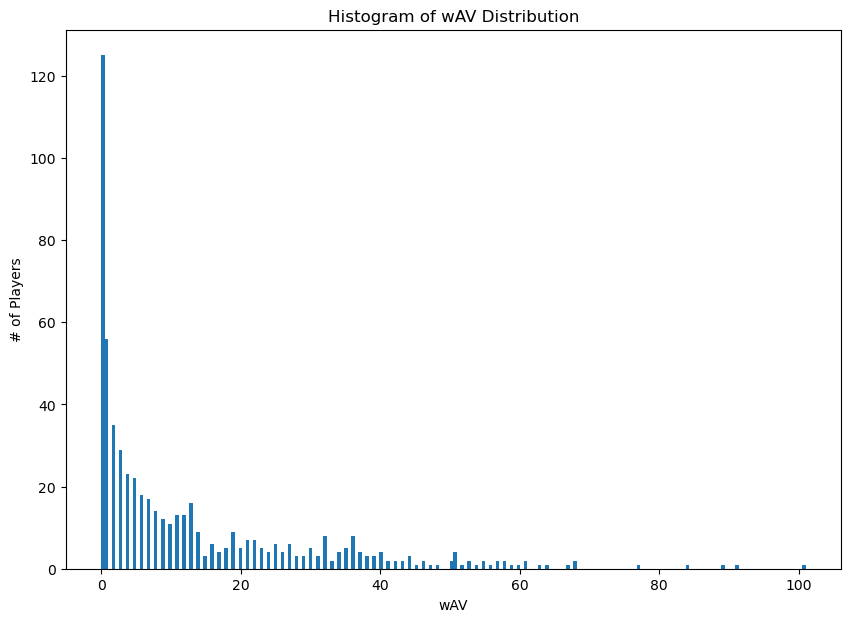

In [153]:
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(wAV_df['wAV'], bins = 200)
plt.xlabel('wAV')
plt.ylabel('# of Players')
plt.title("Histogram of wAV Distribution")
plt.show()

In [198]:
nfl_combine = pd.read_excel('NFL Combine Data.xlsx')
nfl_combine

,Year,Name,College,POS,Height (in),Weight (lbs),Hand Size (in),Arm Length (in),Wonderlic,40 Yard,Bench Press,Vert Leap (in),Broad Jump (in),Shuttle,3Cone,60Yd Shuttle
0,2018,Josh Adams,Notre Dame,RB,74.0,213,9.25,33.75,NaN,NaN,18.0,NaN,NaN,NaN,NaN,NaN
1,2018,Ola Adeniyi,Toledo,DE,74.0,248,9.63,31.75,NaN,4.83,26.0,31.5,NaN,4.28,7.21,12.79
2,2018,Jordan Akins,Central Florida,TE,75.0,249,9.50,32.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018,Jaire Alexander,Louisville,CB,71.0,192,NaN,NaN,NaN,4.38,14.0,35.0,127.0,3.98,6.71,NaN
4,2018,Austin Allen,Arkansas,QB,72.0,210,9.63,30.63,NaN,4.81,NaN,29.5,112.0,4.48,7.18,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10223,1987,Rod Woodson,Purdue,CB,72.0,202,10.50,31.00,NaN,4.33,10.0,36.0,125.0,3.98,NaN,10.92
10224,1987,John Wooldridge,Ohio State,RB,68.4,193,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10225,1987,David Wyman,Stanford,ILB,74.0,235,9.50,31.25,NaN,4.79,23.0,29.0,118.0,4.30,NaN,11.78
10226,1987,Theo Young,Arkansas,TE,74.0,231,9.00,34.00,NaN,4.89,9.0,30.0,107.0,4.20,NaN,11.71


In [199]:
new_df = pd.merge(wAV_df,nfl_combine, left_on="Name",right_on="Name", how = 'left')
new_df

,Name,wAV,Year,College,POS,Height (in),Weight (lbs),Hand Size (in),Arm Length (in),Wonderlic,40 Yard,Bench Press,Vert Leap (in),Broad Jump (in),Shuttle,3Cone,60Yd Shuttle
0,Isaako Aaitui,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Jared Abbrederis,1,2014.0,Wisconsin,WR,73.00,195.0,9.63,31.38,32.0,4.50,4.0,30.5,116.0,4.08,6.80,11.39
2,Mehdi Abdesmad,0,2016.0,Boston College,DT,78.25,284.0,9.75,33.38,NaN,5.10,25.0,29.5,108.0,4.62,7.55,NaN
3,Isa Abdul-Quddus,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Ameer Abdullah,17,2015.0,Nebraska,RB,68.75,205.0,8.63,30.00,NaN,4.60,24.0,42.5,130.0,3.95,6.79,11.18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
607,Brenton Bersin,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608,Sean Berton,1,2003.0,North Carolina State,TE,76.40,279.0,9.75,31.38,NaN,5.04,NaN,31.0,107.0,4.35,7.18,11.71
609,Davone Bess,27,2008.0,Hawaii,WR,69.88,194.0,9.00,30.13,NaN,4.77,12.0,31.5,118.0,4.27,6.97,NaN
610,Jahvid Best,13,2010.0,California,RB,70.13,199.0,NaN,NaN,24.0,4.34,18.0,32.5,113.0,4.17,6.75,NaN


In [200]:
scout_rankings = pd.read_excel('Espn_Grade.xlsx')
scout_rankings['Name'] = scout_rankings['Name'].astype(str)
# scout_rankings['Name'] = scout_rankings['Name'].apply(lambda x: x.replace(".",''))
# remove_digits = str.maketrans('', '', digits)
scout_rankings['Name'] = scout_rankings['Name'].apply(lambda x: x.title())
scout_rankings['Name'] = scout_rankings['Name'].apply(lambda x: ''.join(filter(str.isalnum, x)))
scout_rankings['Name'] = scout_rankings['Name'].apply(lambda x: re.sub(r"\B([A-Z])", r" \1", x))


scout_rankings

,Name,Position,Height,Weight,College,Grade,Position Rank,Overall Rank
0,Shawn Andrews,OT,"6'4½""",345,Arkansas,93.0,2.0,20.0
1,Matthias Askew,DT,"6'5⅜""",301,Michigan State,77.0,10.0,78.0
2,Will Allen,DB,"6'0½""",202,Ohio State,73.0,6.0,95.0
3,Tim Anderson,DT,"6'3⅛""",307,Ohio State,73.0,12.0,90.0
4,Courtney Anderson,TE,"6'6¼""",269,San José State,64.0,9.0,137.0
...,...,...,...,...,...,...,...,...
851,Kirk Ylimiemi,K,"6'0¼""",214,Oregon State,30.0,7.0,NaN
852,Yaacov Yisrael,S,"5'11¼""",198,Penn State,30.0,44.0,NaN
853,Lance Young,WR,"6'0½""",181,Iowa State,30.0,62.0,NaN
854,Corey Yates,CB,"5'9""",177,Southern Miss,20.0,60.0,NaN


In [201]:
new_df = pd.merge(new_df,scout_rankings, left_on="Name",right_on="Name", how = 'left')
new_df

,Name,wAV,Year,College_x,POS,Height (in),Weight (lbs),Hand Size (in),Arm Length (in),Wonderlic,...,Shuttle,3Cone,60Yd Shuttle,Position,Height,Weight,College_y,Grade,Position Rank,Overall Rank
0,Isaako Aaitui,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Jared Abbrederis,1,2014.0,Wisconsin,WR,73.00,195.0,9.63,31.38,32.0,...,4.08,6.80,11.39,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Mehdi Abdesmad,0,2016.0,Boston College,DT,78.25,284.0,9.75,33.38,NaN,...,4.62,7.55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Isa Abdul-Quddus,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Ameer Abdullah,17,2015.0,Nebraska,RB,68.75,205.0,8.63,30.00,NaN,...,3.95,6.79,11.18,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
607,Brenton Bersin,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608,Sean Berton,1,2003.0,North Carolina State,TE,76.40,279.0,9.75,31.38,NaN,...,4.35,7.18,11.71,NaN,NaN,NaN,NaN,NaN,NaN,NaN
609,Davone Bess,27,2008.0,Hawaii,WR,69.88,194.0,9.00,30.13,NaN,...,4.27,6.97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
610,Jahvid Best,13,2010.0,California,RB,70.13,199.0,NaN,NaN,24.0,...,4.17,6.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [202]:
new_df.Grade.isnull().sum()

586

In [212]:
new_df[new_df['Grade'] >20]

,Name,wAV,Year,College_x,POS,Height (in),Weight (lbs),Hand Size (in),Arm Length (in),Wonderlic,...,Shuttle,3Cone,60Yd Shuttle,Position,Height,Weight,College_y,Grade,Position Rank,Overall Rank
35,Mike Adams,57,2012.0,Ohio State,OT,79.25,323.0,10.88,34.00,NaN,...,4.95,7.94,NaN,S,"5'10¼""",189,Delaware,30.0,34.0,NaN
36,Mike Adams,57,1997.0,Texas,WR,71.40,184.0,9.13,31.63,NaN,...,4.38,7.51,11.89,S,"5'10¼""",189,Delaware,30.0,34.0,NaN
37,Mike Adams,57,1987.0,Arizona State,CB,69.80,198.0,8.50,30.50,NaN,...,4.60,NaN,11.91,S,"5'10¼""",189,Delaware,30.0,34.0,NaN
38,Mike Adams,11,2012.0,Ohio State,OT,79.25,323.0,10.88,34.00,NaN,...,4.95,7.94,NaN,S,"5'10¼""",189,Delaware,30.0,34.0,NaN
39,Mike Adams,11,1997.0,Texas,WR,71.40,184.0,9.13,31.63,NaN,...,4.38,7.51,11.89,S,"5'10¼""",189,Delaware,30.0,34.0,NaN
40,Mike Adams,11,1987.0,Arizona State,CB,69.80,198.0,8.50,30.50,NaN,...,4.60,NaN,11.91,S,"5'10¼""",189,Delaware,30.0,34.0,NaN
89,Eric Alexander,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,OLB,"6'2⅛""",223,LSU,30.0,42.0,NaN
100,Roc Alexander,3,2004.0,Washington,CB,71.00,185.0,9.25,31.63,NaN,...,4.23,6.97,11.10,CB,"5'11⅛""",185,Washington,41.0,29.0,277.0
104,Rich Alexis,0,2004.0,Washington,RB,72.00,210.0,9.25,32.50,NaN,...,4.43,7.41,12.10,RB,"6'0""",210,Washington,30.0,34.0,NaN
144,Jared Allen,101,2005.0,Florida Atlantic,QB,74.25,218.0,8.88,30.25,19.0,...,4.39,7.29,NaN,DE,"6'6""",260,Idaho State,51.0,21.0,209.0
